# AI Nutritional Agent

This notebook will try to implement the AI nutritional model proposed in the paper *AI nutrition recommendation using a deep generative model and ChatGPT* by *Ilias Papastratis , Dimitrios Konstantinidis , Petros Daras & Kosmas Dimitropoulos*.

# Imports

In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt

# Data Loader

## Class Definition of the DataSet & Exemple of DataLoader Usage

In [2]:
class MealPlanningDataset(Dataset):
    "Class to load dataset in a pytorch environnement and splitting dataset into training, validation and testing sets"

    def __init__(self, 
                 csv_file: str | None,
                 split: str='train',
                 train_split_ratio: float=0.7, 
                 val_split_ratio: float=0.15, 
                 test_split_ratio: float=0.15,
                 random_seed: int=42):
        """
        Args:
            csv_file (str | None): Path to the CSV file.
            split (str): One of 'train', 'val', or 'test'. Determines which split to use.
            train_pct (float): Fraction of data to use for training.
            val_pct (float): Fraction of data to use for validation.
            test_pct (float): Fraction of data to use for testing.
            random_seed (int): Seed for shuffling the data.
        """
        # Ensure the split percentages add up to 1.0
        total_pct = train_split_ratio + val_split_ratio + test_split_ratio
        if not np.isclose(total_pct, 1.0):
            raise ValueError("train_pct + val_pct + test_pct must equal 1.0")
            
        # Read the data from CSV
        data = pd.read_csv(csv_file)
        
        # Load data into numpy arrays with appropriate types
        self.X = data[["weight", "height", "BMI", "BMR", "PAL", "has_CVD", "has_T2D", "has_iron_def"]].values.astype('float32')
        self.Y_meals = data[['meal_1', 'meal_2', 'meal_3', 'meal_4', 'meal_5', 'meal_6']].values.astype('long') # long : from int32 to int64
        self.target_EI = data[['target_EI']].values.astype('float32')
        self.min_macros = data[['min_prot', 'min_carb', 'min_fat', 'min_sfa']].values.astype('float32')
        self.max_macros = data[['max_prot', 'max_carb', 'max_fat', 'max_sfa']].values.astype('float32')
        
        # Total number of samples
        total_samples = len(self.X)
        indices = np.arange(total_samples)
        
        # Shuffle indices for a random split (using a fixed seed for reproducibility)
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
        # Compute split indices
        train_end = int(train_split_ratio * total_samples)
        val_end = int((train_split_ratio + val_split_ratio) * total_samples)
    
        if split == 'train':
            self.indices = indices[:train_end]
        elif split == 'val':
            self.indices = indices[train_end:val_end]
        elif split == 'test':
            self.indices = indices[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")


    def __len__(self):
        return len(self.indices)


    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        return (
            torch.tensor(self.X[real_idx]),       # X_features
            torch.tensor(self.Y_meals[real_idx]),     # Y_meals
            torch.tensor(self.target_EI[real_idx]),   # target_EI
            torch.tensor(self.min_macros[real_idx]),  # min_macros
            torch.tensor(self.max_macros[real_idx])   # max_macros
        )

In [3]:
dataset_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "..", "..", "ressources", "datasets", "synthetic_nutrition_data.csv")
)
print(dataset_path)

/Users/I743310/Library/CloudStorage/OneDrive-SAPSE/Documents/projects/ai-nutrition-recommendation/ressources/datasets/synthetic_nutrition_data.csv


In [4]:
try :
    train_dataset = MealPlanningDataset(csv_file= dataset_path, split='train')
    val_dataset = MealPlanningDataset(csv_file= dataset_path, split='val')
    test_dataset = MealPlanningDataset(csv_file= dataset_path, split='test')
except ValueError as e:
    print(f"Value error occured: {e}")

In [5]:
dataloader_batch_size = 32

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=dataloader_batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=dataloader_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=dataloader_batch_size)

## Loaded Data (short) Analysis

In [7]:
# Check shapes
for X_features, Y_meals, target_EIs, min_macros, max_macros in train_dataloader:
    print("User information shape : ", X_features.size())
    print("User ground meal plan shape : ", Y_meals.size())
    print("Energy target shape : ", target_EIs.size())
    print("Minimum macronutriments shape : ", min_macros.size())
    print("Maximum macronutriments shape : ", max_macros.size())
    break
print(f"Number of {dataloader_batch_size} batches in training dataloader: {len(train_dataloader)}")
print(f"Total number of samples in training dataset: {len(train_dataloader) * dataloader_batch_size}")

User information shape :  torch.Size([32, 8])
User ground meal plan shape :  torch.Size([32, 6])
Energy target shape :  torch.Size([32, 1])
Minimum macronutriments shape :  torch.Size([32, 4])
Maximum macronutriments shape :  torch.Size([32, 4])
Number of 32 batches in training dataloader: 219
Total number of samples in training dataset: 7008


In [8]:
for X_features, Y_meals, target_EIs, min_macros, max_macros in test_dataloader:
    print("User information shape : ", X_features.size())
    print("User ground meal plan shape : ", Y_meals.size())
    print("Energy target shape : ", target_EIs.size())
    print("Minimum macronutriments shape : ", min_macros.size())
    print("Maximum macronutriments shape : ", max_macros.size())
    break
print(f"Number of {dataloader_batch_size} batches in testing dataloader: {len(test_dataloader)}")
print(f"Total number of samples in testing dataset: {len(test_dataloader) * dataloader_batch_size}")

User information shape :  torch.Size([32, 8])
User ground meal plan shape :  torch.Size([32, 6])
Energy target shape :  torch.Size([32, 1])
Minimum macronutriments shape :  torch.Size([32, 4])
Maximum macronutriments shape :  torch.Size([32, 4])
Number of 32 batches in testing dataloader: 47
Total number of samples in testing dataset: 1504


In [9]:
print(f"Type of data (e.g., X): {type(X_features)}")

Type of data (e.g., X): <class 'torch.Tensor'>


## Encoder

#### Code

In [10]:
class Encoder(nn.Module):
    "Encoder model for the variational auto-encoder (vae)."

    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        """
        Args:
            input_dim (int): input dimension of encoder.
            hidden_dim (int): hidden neurons dimensions.
            latent_dim (int): generated latent space dimension.
        """
        super(Encoder, self).__init__()
        # fc1: projects input features to a hidden representation.
        #   Input: [batch_size, input_dim] → Output: [batch_size, hidden_dim]
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        
        # fc2: further processes the hidden representation.
        #   Input: [batch_size, hidden_dim] → Output: [batch_size, hidden_dim]
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)

        # fc_mu: computes the mean of the latent distribution.
        #   Input: [batch_size, hidden_dim] → Output: [batch_size, latent_dim]
        self.fc_mu = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        
        # fc_logvar: computes the log-variance of the latent distribution.
        #   Input: [batch_size, hidden_dim] → Output: [batch_size, latent_dim]
        self.fc_logvar = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
    
    
    def forward(self, x: torch.Tensor):
        """
        Args:
            x (torch.Tensor): input tensor of encoder.
        """
        # Apply fc1 with ReLU activation.
        #   x: [batch_size, input_dim] → [batch_size, hidden_dim]
        x = F.relu(self.fc1(x))
        
        # Apply fc2 with ReLU activation.
        #   x: [batch_size, hidden_dim] → h: [batch_size, hidden_dim]
        h = F.relu(self.fc2(x))
        
        # Compute the latent mean.
        #   h: [batch_size, hidden_dim] → mu: [batch_size, latent_dim]
        mu = self.fc_mu(h)
        
        # Compute the latent log-variance.
        #   h: [batch_size, hidden_dim] → logvar: [batch_size, latent_dim]
        logvar = self.fc_logvar(h)
        
        return mu, logvar

#### Summary

In [11]:
input_dim = 8
hidden_units = 62
input_dim = 16

encoder = Encoder(input_dim, hidden_units, input_dim)

In [12]:
summary(encoder, (input_dim,), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Encoder                                  [16]                      [16]                      --
├─Linear: 1-1                            [16]                      [62]                      1,054
├─Linear: 1-2                            [62]                      [62]                      3,906
├─Linear: 1-3                            [62]                      [16]                      1,008
├─Linear: 1-4                            [62]                      [16]                      1,008
Total params: 6,976
Trainable params: 6,976
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

## Decoder

#### Code

In [13]:
class Decoder(nn.Module):
    "Decoder model for the variation auto-encoder (vae)"

    def __init__(self, input_dim: int, hidden_units: int, num_classes: int, macro_dim: int):
        """
        Args:
            input_dim (int): Dimensionality of the decoder's input features.
            hidden_units (int): Number of hidden units in the GRU layer, used as both input and output dimensions.
            num_classes (int): Number of target classes to predict (i.e., number of unique meals in the dataset).
            macro_dim (int): Number of macronutrient features in the data.
        """
        super(Decoder, self).__init__()
        self.hidden_units = hidden_units
        self.macro_dim = macro_dim

        # Projects latent vector (shape: [batch_size, latent_dim]) to hidden space (shape: [batch_size, hidden_dim])
        self.latent_to_hidden = nn.Linear(in_features=input_dim, out_features=hidden_units)

        # GRUCell that takes an input of shape [batch_size, hidden_dim] and outputs a hidden state of the same shape
        self.gru1 = nn.GRUCell(input_size=hidden_units, hidden_size=hidden_units)
        self.gru2 = nn.GRUCell(input_size=hidden_units, hidden_size=hidden_units)

        # Classifier head: maps hidden state [batch_size, hidden_dim] to class logits [batch_size, num_classes]
        self.classifier = nn.Linear(in_features=hidden_units, out_features=num_classes)
        # Energy head: maps hidden state [batch_size, hidden_dim] to a scalar energy [batch_size, 1]
        self.energy_head = nn.Linear(in_features=hidden_units, out_features=1)
        # Macro head: maps hidden state [batch_size, hidden_dim] to macro outputs [batch_size, macro_dim]
        self.macro_head = nn.Linear(in_features=hidden_units, out_features=macro_dim) 
    
    def forward(self, z: torch.Tensor):
        """
        Args:
            z (torch.Tensor): Latent vector generated by encoder.
            
        Returns:
            class_logits_seq (torch.Tensor): Sequence of class logits, shape [batch_size, T, num_classes].
            total_energy (torch.Tensor): Summed energy over T time steps, shape [batch_size, 1].
            total_macros (torch.Tensor): Accumulated macro outputs over T time steps, shape [batch_size, macro_dim].
            energies_tensor (torch.Tensor): Sequence of energy values, shape [batch_size, T, 1].
        """
        batch_size = z.size(0)
        T = 6  # Number of GRU time steps


        # Initialize hidden state for GRUCell with zeros, shape: [batch_size, hidden_dim]
        h1 = torch.zeros(size=(batch_size, self.hidden_units), device=z.device)
        h2 = torch.zeros(size=(batch_size, self.hidden_units), device=z.device)
        h_prev = h2

        # Project latent vector to hidden space (input for GRU at t=0), shape: [batch_size, hidden_dim]
        z_projected = self.latent_to_hidden(z)
         
        class_logits_seq = []
        energies_list = []
        # Initialize accumulation for macro outputs, shape: [batch_size, macro_dim]
        total_macros = torch.zeros(batch_size, self.macro_dim, device=z.device)

        for t in range(T):
            # For t=0, use the projected latent vector; for t>0, use previous hidden state as input.
            if t == 0:
                z = z_projected
            else:
                z = h_prev

            # GRUCell update: input z and previous hidden state h, both of shape [batch_size, hidden_dim]
            h1 = self.gru1(z, h1)
            h2 = self.gru2(h1, h2)

            # Compute outputs from the current hidden state
            logits = self.classifier(h2)    # Shape: [batch_size, num_classes]
            energy = self.energy_head(h2)     # Shape: [batch_size, 1]
            macros = self.macro_head(h2)      # Shape: [batch_size, macro_dim]

            class_logits_seq.append(logits)
            energies_list.append(energy)
            total_macros += macros  # Accumulate macro outputs over time steps

            h_prev = h2  # Save current hidden state for next iteration

        # Stack list of tensors along a new time dimension: [batch_size, T, num_classes] and [batch_size, T, 1]
        class_logits_seq = torch.stack(class_logits_seq, dim=1)
        energies_tensor = torch.stack(energies_list, dim=1)
        # Sum energy values over the time dimension, resulting in shape: [batch_size, 1]
        total_energy = energies_tensor.sum(dim=1)

        return class_logits_seq, total_energy, total_macros, energies_tensor

#### Summary

In [14]:
input_dim = 16
hidden_units = 25
num_classes = 140
macro_dim = 5
batch_size = 50

decoder = Decoder(input_dim, hidden_units, num_classes, macro_dim)

In [15]:
summary(decoder, (batch_size, input_dim), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Decoder                                  [50, 16]                  [50, 6, 140]              --
├─Linear: 1-1                            [50, 16]                  [50, 25]                  425
├─GRUCell: 1-2                           [50, 25]                  [50, 25]                  3,900
├─GRUCell: 1-3                           [50, 25]                  [50, 25]                  3,900
├─Linear: 1-4                            [50, 25]                  [50, 140]                 3,640
├─Linear: 1-5                            [50, 25]                  [50, 1]                   26
├─Linear: 1-6                            [50, 25]                  [50, 5]                   130
├─GRUCell: 1-7                           [50, 25]                  [50, 25]                  (recursive)
├─GRUCell: 1-8                           [50, 25]                  [50, 25]                  (recursive)
├─Line

## Variational Encoder

### Loss functions

The same loss functions cited in the paper are used.

In [16]:
def adjust_meal_quantity(energies: torch.Tensor, batch_target_EI: torch.Tensor):
    "Optimizer function [will be used later]"
    pred_total_energy = energies.sum(dim=1)
    d = (batch_target_EI - pred_total_energy) / pred_total_energy
    d_expanded = d.unsqueeze(1)
    adjusted_energies = energies * (1 + d_expanded)
    new_total_energy = adjusted_energies.sum(dim=1)
    return adjusted_energies, new_total_energy   

In [17]:
def compute_L_macro(batch_min_macros: torch.Tensor, batch_max_macros: torch.Tensor, pred_macros: torch.Tensor):
    "Maconutriment penalty loss"
    diff_min = torch.abs(batch_min_macros - pred_macros)
    diff_max = torch.abs(batch_max_macros - pred_macros)
    macro_penalty = diff_min + diff_max
    L_macro = macro_penalty.mean()
    return L_macro

In [18]:
def compute_L_energy(pred_energy: torch.Tensor, batch_target_EI: torch.Tensor):
    "Energy intake loss"
    L_energy = F.mse_loss(pred_energy, batch_target_EI)
    return L_energy

In [19]:
def compute_KLD(mu: torch.Tensor, logvar: torch.Tensor, batch_size: int):
    "Kullback-Leibler Divergence loss"
    KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD_loss = KLD_loss / batch_size
    return KLD_loss

In [20]:
def compute_L_MC(class_logits: torch.Tensor, batch_Y: torch.Tensor):
    "Cross entropy loss"
    T = class_logits.size(1)
    CE_loss = 0.0
    for t in range(T):
        CE_loss += F.cross_entropy(class_logits[:, t, :], batch_Y[:, t])
    CE_loss = CE_loss / T
    return CE_loss

### Optimizer

In [21]:
def optimize_meal_portions(predicted_energy: torch.Tensor,
                           target_energy: torch.Tensor,
                           energies_tensor: torch.Tensor) -> torch.Tensor:
    """
    Adjusts the per-meal energies so that the total daily energy
    matches 'target_energy'.

    Args:
        predicted_energy: shape [batch_size, 1]
        target_energy:    shape [batch_size, 1]
        energies_tensor:  shape [batch_size, T, 1]
    
    Returns:
        scaled_energies:  shape [batch_size, T, 1]
                          scaled so sum(scaled_energies) = target_energy
    """
    # predicted_energy: sum of energies_tensor over T, shape [batch_size, 1]
    # d = (EI - predicted_energy) / predicted_energy
    d = (target_energy - predicted_energy) / predicted_energy  # shape: [batch_size, 1]

    # scale factor for each sample in the batch
    scale_factor = 1.0 + d  # shape: [batch_size, 1]

    # broadcast scale_factor over T time steps
    scaled_energies = energies_tensor * scale_factor.unsqueeze(dim=1)  # [batch_size, T, 1]

    return scaled_energies

### Early stopping
The early stopping is implemented in the training loop. The training stops if the validation loss does not improve for 10 epochs. The model is saved if the validation loss improves. It helps to avoid overfitting and reduces the training time.

In [22]:
class EarlyStopping:
    """
    Implements early stopping to prevent overfitting during training.
    Saves the best model (encoder and decoder) based on validation loss.

    Args:
        patience (int): Number of epochs to wait for improvement before stopping.
        delta (float): Minimum change in validation loss to qualify as an improvement.
    """
    def __init__(self, patience: int= 5, delta: float=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss: float, encoder: nn.Module, decoder: nn.Module):
        """
        Checks if the validation loss has improved. If not, increases the counter.
        Stops training if counter exceeds patience.

        Args:
            val_loss (float): Current validation loss.
            encoder (nn.Module): Encoder model.
            decoder (nn.Module): Decoder model.
        """
        score = -val_loss  # Lower validation loss is better, so we invert the score

        if self.best_score is None:
            # First epoch, initialize best score and save model states
            self.best_score = score
            self.best_model_state = {
                'encoder': encoder.state_dict(),
                'decoder': decoder.state_dict()
            }
        elif score < self.best_score + self.delta:
            # No significant improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Improvement found; update best score and reset counter
            self.best_score = score
            self.best_model_state = {
                'encoder': encoder.state_dict(),
                'decoder': decoder.state_dict()
            }
            self.counter = 0

    def load_best_model(self, encoder: nn.Module, decoder: nn.Module):
        """
        Restores the encoder and decoder to their best recorded states.

        Args:
            encoder (nn.Module): Encoder model to restore.
            decoder (nn.Module): Decoder model to restore.
        """
        encoder.load_state_dict(self.best_model_state['encoder'])
        decoder.load_state_dict(self.best_model_state['decoder'])


### Model

In [23]:
class VariationalAutoencoderTrainer:
    """
    Variational Autoencoder Trainer class that trains its two components:
    an encoder and a decoder.
    """
    def __init__(self, 
                 encoder: Encoder, 
                 decoder: Decoder, 
                 train_loader: DataLoader, 
                 val_loader: DataLoader, 
                 test_loader: DataLoader,
                 optimizer: Adam,
                 early_stopping : EarlyStopping = EarlyStopping(),
                 device: str = 'cpu'):
        """
        Args:
            encoder (nn.Module): Encoder network.
            decoder (nn.Module): Decoder network.
            train_loader (DataLoader): Training data loader.
            val_loader (DataLoader): Validation data loader.
            test_loader (DataLoader): Test data loader.
            optimizer (Adam): Adam optimizer for both encoder and decoder.
            early_stopping (EarlyStopping) : instance of early stopping class.
            device (str): Device on which operations are performed.
        """
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.device = device


    def _compute_loss(self, 
                      user_features: torch.Tensor, 
                      meal_targets: torch.Tensor, 
                      target_energy_intakes: torch.Tensor, 
                      min_macronutrients: torch.Tensor, 
                      max_macronutrients: torch.Tensor):
        """
        Computes the total loss for a batch.

        Args:
            user_features (torch.Tensor): User information tensor (encoder input).
            meal_targets (torch.Tensor): Ground truth daily meals.
            target_energy_intakes (torch.Tensor): Target energy intake values.
            min_macronutrients (torch.Tensor): Minimum targeted macronutrient values.
            max_macronutrients (torch.Tensor): Maximum targeted macronutrient values.

        Returns:
            total_loss (torch.Tensor): Combined loss.
            macro_loss (torch.Tensor): Loss term for macronutrients.
            energy_loss (torch.Tensor): Loss term for energy intake.
            kl_loss (torch.Tensor): KL divergence loss.
            meal_class_loss (torch.Tensor): Loss term for meal classification.
            energies_tensor (torch.Tensor): Output tensor from the decoder regarding energies.
        """
        # Get batch size
        batch_size = user_features.size(0)

        # Forward pass through encoder
        mu, logvar = self.encoder(user_features)
        
        # Reparameterization trick
        epsilon = torch.randn_like(logvar)
        std = torch.exp(0.5 * logvar)
        z = mu + std * epsilon
        
        # Forward pass through decoder
        meal_logits, predicted_energy, predicted_macros, energies_tensor = self.decoder(z)
        
        # Compute individual loss terms
        macro_loss     = compute_L_macro(min_macronutrients, max_macronutrients, predicted_macros)
        energy_loss    = compute_L_energy(predicted_energy, target_energy_intakes)
        kl_loss        = compute_KLD(mu, logvar, batch_size)
        meal_class_loss = compute_L_MC(meal_logits, meal_targets)
        
        total_loss = macro_loss + energy_loss + kl_loss + meal_class_loss
        return total_loss, macro_loss, energy_loss, kl_loss, meal_class_loss, energies_tensor


    def train_epoch(self):
        """
        Performs one training epoch.
        """
        self.encoder.train()
        self.decoder.train()
        total_loss = 0.0
        total_batches = len(self.train_loader)
        
        for batch_idx, (user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients) in enumerate(self.train_loader):
            # Move data to device
            user_features        = user_features.to(self.device)
            meal_targets         = meal_targets.to(self.device)
            target_energy_intakes = target_energy_intakes.to(self.device)
            min_macronutrients   = min_macronutrients.to(self.device)
            max_macronutrients   = max_macronutrients.to(self.device)
            
            self.optimizer.zero_grad()

            loss, macro_loss, energy_loss, kl_loss, meal_class_loss, energies_tensor = self._compute_loss(
                user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients
            )

            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Train Batch {batch_idx+1}/{total_batches} - Loss: {loss.item():.4f} "
                      f"(Macro: {macro_loss.item():.4f}, Energy: {energy_loss.item():.4f}, "
                      f"KLD: {kl_loss.item():.4f}, Meal Classification: {meal_class_loss.item():.4f})")
                
        avg_loss = total_loss / total_batches
        print(f"Training epoch complete. Average Loss: {avg_loss:.4f}\n")
        return avg_loss, energies_tensor


    def validate_epoch(self):
        """
        Evaluates the model on the validation set.
        """
        self.encoder.eval()
        self.decoder.eval()
        total_loss = 0.0
        total_batches = len(self.val_loader)
        
        with torch.no_grad():
            for batch_idx, (user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients) in enumerate(self.val_loader):
                user_features        = user_features.to(self.device)
                meal_targets         = meal_targets.to(self.device)
                target_energy_intakes = target_energy_intakes.to(self.device)
                min_macronutrients   = min_macronutrients.to(self.device)
                max_macronutrients   = max_macronutrients.to(self.device)
                
                loss, _, _, _, _, _ = self._compute_loss(
                    user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients
                )
                total_loss += loss.item()
                
        avg_loss = total_loss / total_batches
        print(f"Validation epoch complete. Average Loss: {avg_loss:.4f}\n")
        return avg_loss


    def train(self, num_epochs: int):
        """
        Trains the model for the specified number of epochs.
        
        Args:
            num_epochs (int): Number of epochs to run.
            early_stopping (int): Number of epoche to run
        
        Returns:
            train_losses (list): List of average training losses.
            val_losses (list): List of average validation losses.
        """
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            train_loss, _ = self.train_epoch()
            val_loss = self.validate_epoch()
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            self.early_stopping(val_loss, self.encoder, self.decoder)
            if self.early_stopping.early_stop:
                print("Early stopping")
                self.early_stopping.load_best_model(self.encoder, self.decoder)
                break
        return train_losses, val_losses, self.encoder, self.decoder


    def predict(self, user_features: torch.Tensor):
        """
        Generates predictions given input features.
        
        Returns:
            meal_logits, predicted_energy, predicted_macros, energies_tensor
        """
        self.encoder.eval()
        self.decoder.eval()
        with torch.no_grad():
            user_features = user_features.to(self.device)
            # For prediction we use the mean (mu) as the latent representation.
            mu, _                                                            = self.encoder(user_features)
            meal_logits, predicted_energy, predicted_macros, energies_tensor = self.decoder(mu)
        return meal_logits, predicted_energy, predicted_macros, energies_tensor


    def evaluate(self):
        """
        Evaluates the model on both training and test datasets.
        
        Returns:
            dict: Dictionary containing average training and test losses.
        """
        self.encoder.eval()
        self.decoder.eval()
        
        # Evaluate on training data
        total_train_loss = 0.0
        for user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients in self.train_loader:
            user_features         = user_features.to(self.device)
            meal_targets          = meal_targets.to(self.device)
            target_energy_intakes = target_energy_intakes.to(self.device)
            min_macronutrients    = min_macronutrients.to(self.device)
            max_macronutrients    = max_macronutrients.to(self.device)
            
            with torch.no_grad():
                loss, _, _, _, _, _ = self._compute_loss(
                    user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients
                )
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(self.train_loader)
        
        # Evaluate on test data
        total_test_loss = 0.0
        for user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients in self.test_loader:
            user_features         = user_features.to(self.device)
            meal_targets          = meal_targets.to(self.device)
            target_energy_intakes = target_energy_intakes.to(self.device)
            min_macronutrients    = min_macronutrients.to(self.device)
            max_macronutrients    = max_macronutrients.to(self.device)
            
            with torch.no_grad():
                loss, _, _, _, _, _ = self._compute_loss(
                    user_features, meal_targets, target_energy_intakes, min_macronutrients, max_macronutrients
                )
            total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(self.test_loader)
        
        print(f"Evaluation complete. Average Training Loss: {avg_train_loss:.4f}, Average Test Loss: {avg_test_loss:.4f}\n")
        return avg_train_loss, avg_test_loss
    
    
    def predict_meal_plan(self, user_features: torch.Tensor, target_energy: torch.Tensor):
        """
        Predicts the user's meal plan and scales portions so total energy = target.
        
        Args:
            user_features: [batch_size, input_dim]
            target_energy: [batch_size, 1]
        
        Returns:
            pred_meal_plan: shape [batch_size, T] (the chosen meal IDs)
            scaled_energies: shape [batch_size, T, 1]
            total_macros: shape [batch_size, macro_dim] (unchanged)
        """
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            user_features = user_features.to(self.device)
            target_energy = target_energy.to(self.device)

            # 1) Forward pass
            mu, _ = self.encoder(user_features)
            class_logits_seq, predicted_energy, predicted_macros, energies_tensor = self.decoder(mu)
            
            # 2) Pick meals (argmax)
            pred_meal_plan = torch.argmax(class_logits_seq, dim=2)  # [batch_size, T]

            # 3) Scale only the meal energies
            scaled_energies = optimize_meal_portions(
                predicted_energy=predicted_energy, 
                target_energy=target_energy,
                energies_tensor=energies_tensor
            )
            
        # Return final plan + scaled portion energies
        return pred_meal_plan, scaled_energies, predicted_macros

## Training

In [24]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [25]:
dataset_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "..", "..", "ressources", "datasets", "synthetic_nutrition_data.csv")
)
print(dataset_path)

/Users/I743310/Library/CloudStorage/OneDrive-SAPSE/Documents/projects/ai-nutrition-recommendation/ressources/datasets/synthetic_nutrition_data.csv


In [26]:
train_dataset = MealPlanningDataset(csv_file=dataset_path, split='train')
val_dataset = MealPlanningDataset(csv_file=dataset_path, split='val')
test_dataset = MealPlanningDataset(csv_file=dataset_path, split='test')

In [27]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [28]:
# Encoder args
input_dim_enc = 8
hidden_dim = 256
input_dim = 256

# Decoder args
input_dim_dec = input_dim
hidden_units = 512
num_classes = 10
macro_dim = 4

In [29]:
encoder.parameters()

<generator object Module.parameters at 0x132f475a0>

In [30]:
early_stopping = EarlyStopping(40, 0)

In [31]:
optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1E-4)

In [32]:
encoder = Encoder(input_dim=input_dim_enc, hidden_dim=hidden_dim, latent_dim=input_dim)
decoder = Decoder(input_dim=input_dim_dec, hidden_units=hidden_units, num_classes=num_classes, macro_dim=macro_dim)

In [33]:
vae_trainer = VariationalAutoencoderTrainer(encoder, decoder, train_dataloader, val_dataloader, test_dataloader, optimizer, early_stopping, device)

In [34]:
epochs = 500
train_loss, val_loss, encoder, decoder = vae_trainer.train(num_epochs=epochs)

Epoch 1/500
Train Batch 10/110 - Loss: 7.0549 (Macro: 1.5452, Energy: 1.1232, KLD: 2.0810, Meal Classification: 2.3054)
Train Batch 20/110 - Loss: 6.7288 (Macro: 1.5334, Energy: 1.0091, KLD: 1.8867, Meal Classification: 2.2997)
Train Batch 30/110 - Loss: 6.9013 (Macro: 1.5054, Energy: 1.0319, KLD: 2.0606, Meal Classification: 2.3034)
Train Batch 40/110 - Loss: 7.2355 (Macro: 1.5280, Energy: 1.2266, KLD: 2.1761, Meal Classification: 2.3048)
Train Batch 50/110 - Loss: 6.7308 (Macro: 1.4812, Energy: 1.0075, KLD: 1.9372, Meal Classification: 2.3049)
Train Batch 60/110 - Loss: 6.7275 (Macro: 1.4510, Energy: 0.9556, KLD: 2.0197, Meal Classification: 2.3013)
Train Batch 70/110 - Loss: 6.6873 (Macro: 1.4074, Energy: 0.8278, KLD: 2.1471, Meal Classification: 2.3049)
Train Batch 80/110 - Loss: 7.0848 (Macro: 1.4429, Energy: 1.0332, KLD: 2.3038, Meal Classification: 2.3048)
Train Batch 90/110 - Loss: 6.5829 (Macro: 1.4223, Energy: 0.9262, KLD: 1.9334, Meal Classification: 2.3010)
Train Batch 100/

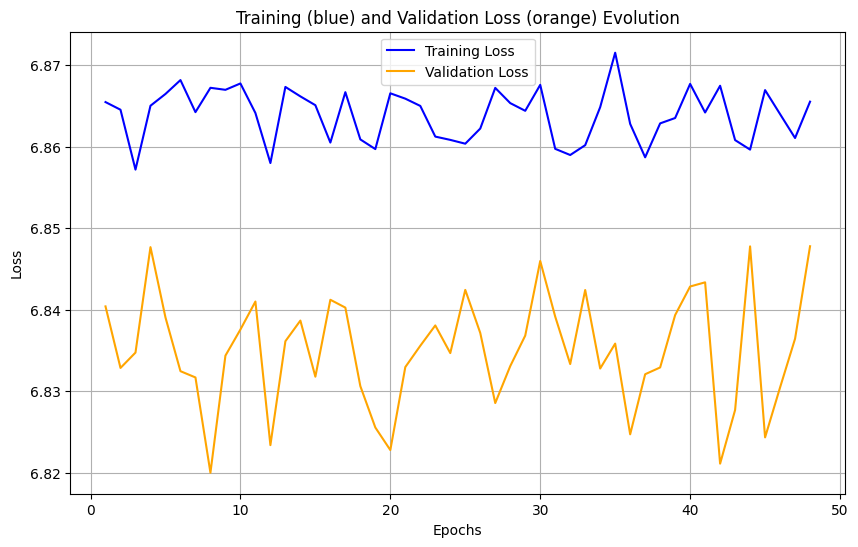

In [35]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training (blue) and Validation Loss (orange) Evolution')
plt.legend()
plt.grid(True)
plt.show()

### Save model

In [36]:
def save_model(name: str, encoder: nn.Module, decoder: nn.Module):
    "function to save encoder & decoder states"
    model_path = os.path.abspath(
        os.path.join(os.getcwd(), "..", "..", "..", "ressources", "assets", f"{name}.pth")
    )

    torch.save({
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }, model_path)

In [37]:
save_model("variation_autoencoder", encoder, decoder)

# Credits

I have read multiple blogs to implement this model. Unfortunately, I have not documented them. I will try to credit the most important ones here.

[AI nutrition recommendation using a deep generative model and ChatGPT](https://www.nature.com/articles/s41598-024-65438-x) : the paper that developed the model.

[Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) : How to implement code for training a model with PyTorch.

[GPT o3-mini-high](https://chatgpt.com/) : explanations, commenting, debugging and references.

[PyTorch](https://pytorch.org/) : the library used to implement the model.

[Modern PyTorch Techniques for VAEs: A Comprehensive Tutorial](https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/)
[How to handle overfitting in PyTorch models using Early Stopping](https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/): Code to implement early stopping in PyTorch models.